# Equilibrium Fitting

In [1]:
using Revise
using DelimitedFiles
using Statistics
using Distributions
using LaTeXStrings

In [2]:
using Plots
gr()

Plots.GRBackend()

In [3]:
include("../src/vafdyn.jl")
using .VAFDyn

## Load Data

In [4]:
untypedM = readdlm("../data/Shearwater_calls_FDR0.95_all_muts.txt", '\t', Any; skipstart=1)
untypedM = untypedM[:, 5: end-1]
replace!(untypedM, "NA"=>0)
variants_var_col = Array{Int}(untypedM);

In [5]:
HSCMask_col = fill(false, size(variants_var_col, 2))
HSCBMMask_col = fill(false, size(variants_var_col, 2))
HSCBMMask_col[1:73] .= true
HSCMask_col[1:73] .= true
HSCMask_col[125:end] .= true
HPCMask_col = .!HSCMask_col;
mutBurden_col = sum(variants_var_col, dims=1);

### VAF data

In [6]:
vaf_var = sum(variants_var_col, dims=2) / 140
vafHSC_var = sum(variants_var_col[:, HSCMask_col], dims=2);
vafHPC_var = sum(variants_var_col[:, HPCMask_col], dims=2) / sum(HPCMask_col);

vafHSCBM_var = sum(variants_var_col[:, HSCBMMask_col], dims=2) / sum(HSCBMMask_col)

vafAbsHSC_var = sum(variants_var_col[:, HSCMask_col], dims=2);
vafAbsHSCBM_var = sum(variants_var_col[:, HSCBMMask_col], dims=2);

In [7]:
function makeHist(varPrev_var, N::Integer)
    n_f = zeros(Int64, N+1)
    for m in 1:N
        n_f[1+m] = length(findall(x -> x==m, varPrev_var))
    end
    return n_f
end

vafHSC_f = makeHist(vafAbsHSC_var, sum(HSCMask_col));
vafHSCBM_f = makeHist(vafAbsHSCBM_var, sum(HSCBMMask_col));

println(vafHSC_f[2])

78721


## Fit VAF

In [8]:
# function eqVAFSample(p, μ, N, S)
#     freqs_f = (0:N)/N
#     vEq_f = (2 + p/(1-p))*μ ./ freqs_f
#     vEqS_f = VAFDyn.sampler(vEq_f, N, S)
#     return vEqS_f
# end

# function eqVAF(p, μ, N, S)
#     freqs_f = (0:N)/N
#     vEq_f = (2. + p/(1-p))*μ ./ freqs_f
#     return vEq_f
# end

function eqVAF1(p::Real, μ::Real, N::Real)
    (2 + p/(1-p)) * μ * N
end

eqVAF1 (generic function with 1 method)

In [9]:
# @time testVaf_f = eqVAFSample(0, 1, 100000, 435);
# println(testVaf_f[2])
# println(vafHSC_f[2])
# println(testVaf_f[2]-vafHSC_f[2])

### find Max N

In [18]:
μ1 = 1.2
μ2 = 4.2 
S = sum(HSCMask_col)
vRef = vafHSC_f[2]

NVals_j = 10^4:10^3:5*10^4

vDistμ1_nMax = Array{Float64,1}(undef, length(NVals_j))
vDistμ2_nMax = Array{Float64,1}(undef, length(NVals_j))
@time for (j,N) in enumerate(NVals_j)
    eq1μ1 = eqVAF1(0, μ1, N)
    eq1μ2 = eqVAF1(0, μ2, N)
    vDistμ1_nMax[j] = eq1μ1 - vRef
    vDistμ2_nMax[j] = eq1μ2 - vRef
end


  0.000037 seconds (411 allocations: 10.281 KiB)


In [27]:
μ1 = 1.2
μ2 = 4.2
S = sum(HSCMask_col)
vRef = vafHSC_f[2]

pVals_i = 0:0.01:0.99
NVals_j = 1*10^4:10^2:5*10^4

v1_p_N = Array{Float64, 2}(undef, length(pVals_i), length(NVals_j))
vDist_p_N = Array{Float64, 2}(undef, length(pVals_i), length(NVals_j))
nSolved1_p = Array{Float64,1}(undef, length(pVals_i))
nSolved2_p = Array{Float64,1}(undef, length(pVals_i))
@time for (i,p) in enumerate(pVals_i)
    nSolved1_p[i] = vRef / ((2 + p/(1-p))*μ1)
    nSolved2_p[i] = vRef / ((2 + p/(1-p))*μ2)
    for (j,N) in enumerate(NVals_j)
        
        vEq1 = eqVAF1(p, μ, N)
        vDist_p_N[i,j] = vEq1 - vRef
        
        if (vEq1-vRef)>1000
            vDist_p_N[i,j] = 1000
        end
        if (vEq1-vRef)<-1000
            vDist_p_N[i,j] = -1000
        end
#         v1_p_N[i,j] = vEq1
#         println(vDist_p_N[i,j])
        
    end
end


  0.038721 seconds (403.00 k allocations: 9.834 MiB)


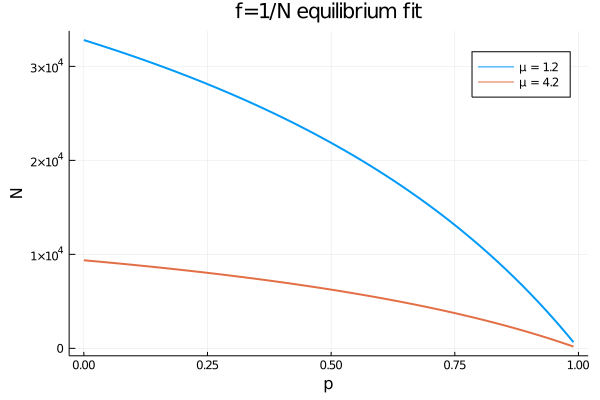

In [31]:
# h1 = heatmap(pVals_i, NVals_j, abs.(vDist_p_N))
# xlabel!("p")
# ylabel!("N")
# display(h1)

p2 = plot(pVals_i, nSolved1_p,
        linewidth=2,
#         dpi=300,
        label="μ = "*string(μ1))
plot!(pVals_i, nSolved2_p,
        linewidth=2,
        label="μ = "*string(μ2))
xlabel!("p")
ylabel!("N")
title!("f=1/N equilibrium fit")
display(p2)
# savefig(p2, "../figures/p-N_dependence.png")
